# Electric Vehicle Presence Discovery

In [2]:
#import packages
import datetime as dat
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats as stats
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [3]:

#load data
df = pd.read_csv('Data/dataframe.csv')

#drop the unamed column
df = df.drop(['Unnamed: 0'], axis=1)
#view data
df.head()

,dataid,use,building_type,city,pv,total_square_footage,EV,age_of_house
0,59,46067.678810,1,1,0,3825.0,0,8.0
1,77,43064.619488,1,1,1,2669.0,0,10.0
2,86,39295.153227,1,1,0,1788.0,0,71.0
3,93,27631.404293,1,1,1,2934.0,0,26.0
4,94,18164.954785,1,1,0,1713.0,0,44.0


In [4]:
#deal with class imblanance

#first divide into target and features
# Specify the name of the target
target = 'EV'

# Get the target vector
y= df[target]

features = df.drop('dataid', axis=1)
# Specify the name of the features
features = list(features.drop(target,axis=1).columns)


# Get the feature vector
x= df[features]



#oversampling
from imblearn import over_sampling, under_sampling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 1)
x_res, y_res = sm.fit_sample(x, y)


from sklearn.model_selection import train_test_split

# Randomly choose 30% of the data for testing (using random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.3, random_state=0, stratify=y_res)

<Figure size 432x288 with 0 Axes>

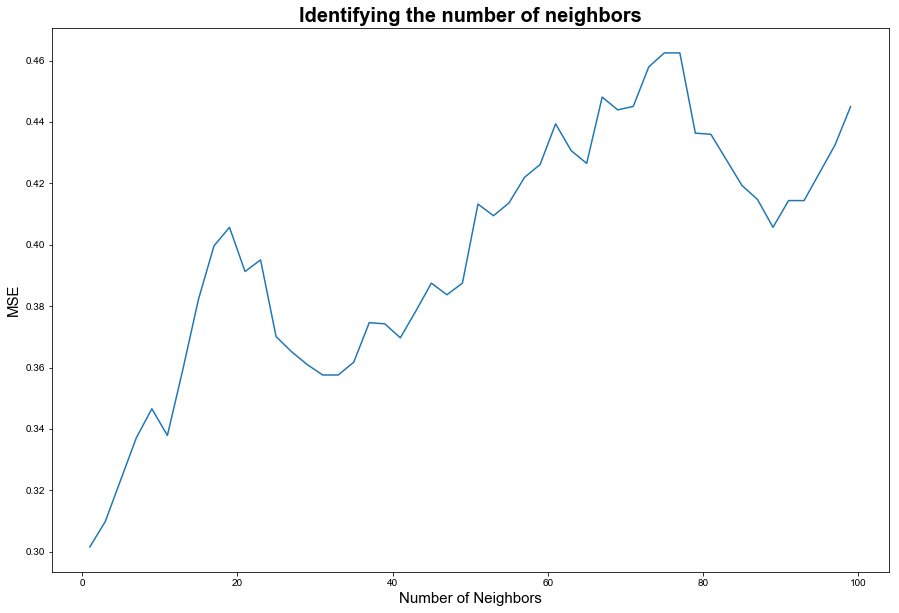

In [6]:
#choose the best n_neighbors for KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
#try to plot KNN
#creating list of K for KNN
k_list = list(range(1,100,2))
# create a new list called cv_scores
cv_scores = []

# perform 10-fold cross validation
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
# find MSE
MSE = [1 - x for x in cv_scores]
#make a plot
plt.figure()
plt.figure(figsize=(15,10))
plt.title('Identifying the number of neighbors', fontsize=20, fontweight='bold')
plt.xlabel('Number of Neighbors', fontsize=15)
plt.ylabel('MSE', fontsize=15)
sns.set_style("whitegrid")
plt.plot(k_list, MSE)

plt.show()

#This pattern shows that less numbers may reduce MSE

## Model Building

In [5]:
# models to try

#Logistic Regression
#K Nearest Neighbor
#Perceptron
#Decision Tree
#Support Vector Machine
#Random Forest

#import machine learning packages
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
#from sklearn.ensemble import RandomForestClassifier


In [24]:
#create clfs
clfs = {'lr': LogisticRegression(random_state=0),
        'knn':KNeighborsClassifier(),
        'mlp': MLPClassifier(random_state=0),
        'rf': RandomForestClassifier(random_state=0)}
        'svc': SVC(random_state=0)}

In [7]:
#create pipline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

thresholds = [0, .1, .15, .2]

pipe_clfs = {}

for name, clf in clfs.items():
    pipe_clfs[name] = {}
    for threshold in thresholds:
        pipe_clfs[name][threshold] = Pipeline([('StandardScaler', StandardScaler()), 
                                               ('SelectFromModel', SelectFromModel(estimator=RandomForestClassifier(random_state=0), 
                                                                                   threshold=threshold)), 
                                               ('clf', clf)])

In [8]:
#create paramter grids
param_grids = {}

In [9]:
#Logistic Regression
param_grid = [{'clf__multi_class': ['ovr'], 
               'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]

param_grids['lr'] = param_grid

In [10]:

#KNN

#create parameter grid for KNN
param_grid = [{'clf__n_neighbors': [2,3,4,5], 
               'clf__algorithm':['auto','brute','kd_tree','ball_tree']}]
param_grids['knn'] = param_grid

In [11]:

#perceptron
param_grid = [{'clf__hidden_layer_sizes': [50, 100, 150],
               'clf__activation': ['identity', 'logistic', 'tanh', 'relu']}]

param_grids['mlp'] = param_grid

In [12]:
#create parameter grid for SVC
param_grid = [{'clf__C': [0.1, 1, 10, 20, 50],
               'clf__gamma': [0.1, 1, 10, 20, 50],
               'clf__kernel': ['rbf', 'sigmoid']}]

param_grids['svc'] = param_grid

In [13]:
#create parameter grid for random forest
param_grid = [{'clf__n_estimators': [10, 20, 30, 40, 50],
              'clf__min_samples_split': [7, 8, 9, 10, 15],
               'clf__min_samples_leaf': [1, 2, 3, 4, 5]}]

param_grids['rf'] = param_grid

In [16]:

# The start time
start = time.time()




# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []
#scoring = ['accuracy', 'precision', 'recall', 'f1']


# For each classifier
for name in pipe_clfs.keys():
    for threshold in thresholds:
        # GridSearchCV
        gs = GridSearchCV(estimator=pipe_clfs[name][threshold],
                          scoring='accuracy',
                          param_grid=param_grids[name],
                          n_jobs=1,
                          cv=StratifiedKFold(n_splits=5,
                                             shuffle=False,
                                           random_state=0))
        # Fit the pipeline
        gs = gs.fit(X_train, y_train)

        # Update best_score_param_estimators
        best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
        
# The end time
end = time.time()

# Print the Run time
print('Run time: ' + str(end - start))

C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Run time: 24.368727445602417


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
gs.cv_results_

In [17]:
# Sort best_score_param_estimators in descending order of the best_score_
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# Print the best_estimator
print('best_estimator:', end=' ')
print(best_score_param_estimators[0][2].named_steps['clf'], end='\n\n')

# Print the threshold used by the best_estimator
print('threshold:', end=' ')
print(best_score_param_estimators[0][2].named_steps['SelectFromModel'].threshold_)

#print the score
print('score:', end='')
print(best_score_param_estimators[0][0])

print(len(best_score_param_estimators))

best_estimator: SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

threshold: 0.15
score:0.793859649122807
4


In [ ]:
best_score_param_estimators[0]

In [18]:
#confusion matrix
i = [0,1]

from sklearn.metrics import confusion_matrix
y_pred = best_score_param_estimators[0][2].predict(X_train)
cm =  confusion_matrix(y_train,y_pred)
print(cm)

TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

print(TN, FP, FN, TP)


[[109   5]
 [  0 114]]
109 5 0 114


In [19]:
#create recall, precision, F1, Sensitivyt and specificty from matrix

recall = TP/(TP+FN)
precision = TP/(TP+FP)
Sensitivity = TP/(TP+FN)
Specificity = TN/ (TN+FP)

print('recall is', recall)
print('precision is', precision)
print('sensitivity is', Sensitivity)
print('specificity is', Specificity)

recall is 1.0
precision is 0.957983193277311
sensitivity is 1.0
specificity is 0.956140350877193


In [28]:
#predict target based on best model
y_pred_test = best_score_param_estimators[0][2].predict(X_test)
cm_test =  confusion_matrix(y_test,y_pred_test)
print(cm_test)
TrueN = cm_test[0][0]
FalseP = cm_test[0][1]
FalseN = cm_test[1][0]
TrueP = cm_test[1][1]

print(TrueN, FalseP, FalseN, TrueP)


[[46  3]
 [ 0 49]]
46 3 0 49


In [29]:
#create recall, precision, F1, Sensitivyt and specificty from matrix

recall_test = TrueP/(TrueP+FalseN)
precision_test = TrueP/(TrueP+FalseP)
Sensitivity_test = TrueP/(TrueP+FalseN)
Specificity_test = TrueN/ (TrueN+FalseP)
Accuracy = (TrueP + TrueN) / (TrueP + TrueN + FalseP + FalseN)
print('recall is', recall_test)
print('precision is', precision_test)
print('sensitivity is', Sensitivity_test)
print('specificity is', Specificity_test)
print('Accuracy is', Accuracy)

recall is 1.0
precision is 0.9423076923076923
sensitivity is 1.0
specificity is 0.9387755102040817
Accuracy is 0.9693877551020408


In [22]:
#turn best score parameter into a dictionary

#key is clf and value is best score

#reverse sort best_score_param_estimmators
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0])

accuracy = [{'model':p[2].named_steps['clf'], 'threshold':p[2].named_steps['SelectFromModel'].threshold_, 'accuracy':p[0]} for p in best_score_param_estimators]

In [ ]:
pd.DataFrame.from_records(accuracy)

# Now Let's try the pipline and see the best estimator using precision

In [ ]:
# The start time
start = time.time()


#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import StratifiedKFold
# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []

# For each classifier
for name in pipe_clfs.keys():
    for threshold in thresholds:
        # GridSearchCV
        gs = GridSearchCV(estimator=pipe_clfs[name][threshold],
                          param_grid=param_grids[name],
                          scoring='precision',
                          n_jobs=1,
                          cv=StratifiedKFold(n_splits=5,
                                             shuffle=False,
                                           random_state=0))
        # Fit the pipeline
        gs = gs.fit(X_train, y_train)

        # Update best_score_param_estimators
        best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
        
# The end time
end = time.time()

# Print the Run time
print('Run time: ' + str(end - start))

In [ ]:
# Sort best_score_param_estimators in descending order of the best_score_
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# Print the best_estimator
print('best_estimator:', end=' ')
print(best_score_param_estimators[0][2].named_steps['clf'], end='\n\n')

# Print the threshold used by the best_estimator
print('threshold:', end=' ')
print(best_score_param_estimators[0][2].named_steps['SelectFromModel'].threshold_)


#print the score
print('score:', end='')
print(best_score_param_estimators[0][0])

In [ ]:
#confusion matrix
y_pred = best_score_param_estimators[0][2].predict(X_train)
confusion_matrix(y_res,y_pred)



In [ ]:
precision = [{'model':p[2].named_steps['clf'], 'threshold':p[2].named_steps['SelectFromModel'].threshold_, 'precision':p[0]} for p in best_score_param_estimators]

pd.DataFrame.from_records(precision)

# Now Let's find the best estmator for recall

In [ ]:
# The start time
start = time.time()


#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import StratifiedKFold
# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []

# For each classifier
for name in pipe_clfs.keys():
    for threshold in thresholds:
        # GridSearchCV
        gs = GridSearchCV(estimator=pipe_clfs[name][threshold],
                          param_grid=param_grids[name],
                          scoring='recall',
                          n_jobs=1,
                          cv=StratifiedKFold(n_splits=5,
                                             shuffle=False,
                                           random_state=0))
        # Fit the pipeline
        gs = gs.fit(X_train, y_train)

        # Update best_score_param_estimators
        best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
        
# The end time
end = time.time()

# Print the Run time
print('Run time: ' + str(end - start))

In [ ]:
# Sort best_score_param_estimators in descending order of the best_score_
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# Print the best_estimator
print('best_estimator:', end=' ')
print(best_score_param_estimators[0][2].named_steps['clf'], end='\n\n')

# Print the threshold used by the best_estimator
print('threshold:', end=' ')
print(best_score_param_estimators[0][2].named_steps['SelectFromModel'].threshold_)


#print the score
print('score:', end='')
print(best_score_param_estimators[0][0])

In [ ]:
#confusion matrix
y_pred = best_score_param_estimators[0][2].predict(X_train)
confusion_matrix(y_train,y_pred)


In [ ]:
recall = [{'model':p[2].named_steps['clf'], 'threshold':p[2].named_steps['SelectFromModel'].threshold_, 'recall':p[0]} for p in best_score_param_estimators]

pd.DataFrame.from_records(recall)

# Now Let's look for f1 score

In [25]:
# The start time
start = time.time()


#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import StratifiedKFold
# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []

# For each classifier
for name in pipe_clfs.keys():
    for threshold in thresholds:
        # GridSearchCV
        gs = GridSearchCV(estimator=pipe_clfs[name][threshold],
                          param_grid=param_grids[name],
                          scoring='f1',
                          n_jobs=1,
                          cv=StratifiedKFold(n_splits=5,
                                             shuffle=False,
                                           random_state=0))
        # Fit the pipeline
        gs = gs.fit(X_train, y_train)

        # Update best_score_param_estimators
        best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
        
# The end time
end = time.time()

# Print the Run time
print('Run time: ' + str(end - start))

C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 

C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Run time: 27.88329792022705


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
# Sort best_score_param_estimators in descending order of the best_score_
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# Print the best_estimator
print('best_estimator:', end=' ')
print(best_score_param_estimators[0][2].named_steps['clf'], end='\n\n')

# Print the threshold used by the best_estimator
print('threshold:', end=' ')
print(best_score_param_estimators[0][2].named_steps['SelectFromModel'].threshold_)


#print the score
print('score:', end='')
print(best_score_param_estimators[0][0])

best_estimator: SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

threshold: 0.15
score:0.8257911743076753


In [ ]:
#confusion matrix
y_pred = best_score_param_estimators[0][2].predict(X_train)
confusion_matrix(y_train,y_pred)


In [ ]:
f1 = [{'model':p[2].named_steps['clf'], 'threshold':p[2].named_steps['SelectFromModel'].threshold_, 'f1':p[0]} for p in best_score_param_estimators]

pd.DataFrame.from_records(f1)

In [20]:
#confusion matrix
i = [0,1]

from sklearn.metrics import confusion_matrix
y_pred = best_score_param_estimators[0][2].predict(x_res)
cm =  confusion_matrix(y_res,y_pred)
print(cm)

TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

print(TN, FP, FN, TP)

[[155   8]
 [  1 162]]
155 8 1 162


In [23]:
#create recall, precision, F1, Sensitivyt and specificty from matrix

recall = TP/(TP+FN)
precision = TP/(TP+FP)
Sensitivity = TP/(TP+FN)
Specificity = TN/ (TN+FP)
Accuracy = (TP + TN) / (TP + TN + FP + FN)
f1 = 2*((recall*precision)/(precision+recall))


print('recall is', recall)
print('precision is', precision)
print('sensitivity is', Sensitivity)
print('specificity is', Specificity)
print('Accuracy is', Accuracy)
print('f1 is' f1)

recall is 0.9938650306748467
precision is 0.9529411764705882
sensitivity is 0.9938650306748467
specificity is 0.950920245398773
Accuracy is 0.9723926380368099


In [ ]:
#predict target based on best model
y_pred_test = best_score_param_estimators[0][2].predict(X_test)
cm_test =  confusion_matrix(y_test,y_pred_test)
print(cm_test)
TrueN = cm_test[0][0]
FalseP = cm_test[0][1]
FalseN = cm_test[1][0]
TrueP = cm_test[1][1]

print(TrueN, FalseP, FalseN, TrueP)


In [ ]:
#create recall, precision, F1, Sensitivyt and specificty from matrix

recall_test = TrueP/(TrueP+FalseN)
precision_test = TrueP/(TrueP+FalseP)
Sensitivity_test = TrueP/(TrueP+FalseN)
Specificity_test = TrueN/ (TrueN+FalseP)
Accuracy = (TrueP + TrueN) / (TrueP + TrueN + FalseP + FalseN)
f1 = 2*((recall*precision)/(precision+recall))

print('recall is', recall_test)
print('precision is', precision_test)
print('sensitivity is', Sensitivity_test)
print('specificity is', Specificity_test)
print('Accuracy is', Accuracy)
print('f1 is', f1)